In [1]:
import numpy as np
import pandas as pd
from constants import *
from core.tools.time_series import *
from core.tools.data_import import *
import matplotlib
import matplotlib.pyplot as plt

In [2]:
df = load_dataset(UNRATE_DIR["MAC"])

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64


In [3]:
dd = differencing(df, order=2, periods=1)
d2 = differencing(df, order=2, periods=[1,1])

In [4]:
print(df.head())
print(dd.head())
print(d2.head())

            UNRATE
DATE              
1948-01-01     3.4
1948-02-01     3.8
1948-03-01     4.0
1948-04-01     3.9
1948-05-01     3.5
            UNRATE_period1_order2
DATE                             
1948-01-01                    NaN
1948-02-01                    NaN
1948-03-01                   -0.2
1948-04-01                   -0.3
1948-05-01                   -0.3
            UNRATE_period[1, 1]_order2
DATE                                  
1948-01-01                         NaN
1948-02-01                         NaN
1948-03-01                        -0.2
1948-04-01                        -0.3
1948-05-01                        -0.3


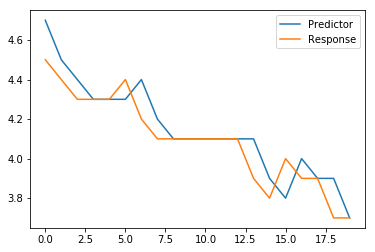

In [4]:
plt.plot(X[-1])
plt.plot(y[-1])
plt.legend(["Predictor", "Response"])